# Project: Toxic Comment Classfication

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, GRU,Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

% matplotlib inline
#import keras.backend as K

In [3]:
# Source of data:https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Source of word vectors: http://nlp.stanford.edu/data/glove.6B.zip
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 5

In [4]:
# load in pre-trained word vectors
word2vec = {}
with open('glove.6B.%sd.txt' % EMBEDDING_DIM, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [5]:
# prepare text samples and their labels
train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# word to integer mapping
word2idx = tokenizer.word_index
# pad sequences to get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [7]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [8]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
#x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 202s - loss: 0.0671 - acc: 0.9773 - val_loss: 0.0608 - val_acc: 0.9790
Epoch 2/5
127656/127656 [==============================] - 203s - loss: 0.0583 - acc: 0.9794 - val_loss: 0.0576 - val_acc: 0.9795
Epoch 3/5
127656/127656 [==============================] - 198s - loss: 0.0562 - acc: 0.9800 - val_loss: 0.0570 - val_acc: 0.9799
Epoch 4/5
127656/127656 [==============================] - 199s - loss: 0.0548 - acc: 0.9805 - val_loss: 0.0568 - val_acc: 0.9802
Epoch 5/5
127656/127656 [==============================] - 199s - loss: 0.0543 - acc: 0.9806 - val_loss: 0.0550 - val_acc: 0.9803


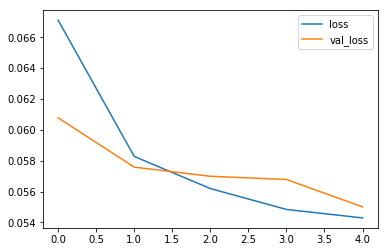

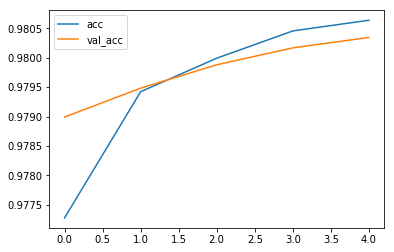

0.974334991452


In [9]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))